In [ ]:
## 1. Transform data to record format
## First dataset from http://www.robots.ox.ac.uk/~vgg/data/scenetext/
## This method failed, because 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math
import numpy as np
import scipy.io as sio
import gzip
from zipfile import ZipFile
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../processing/')
from datasets import sythtextprovider
import tensorflow as tf
import skimage.io as skio
#tf.InteractiveSession()
from PIL import Image
import re
import os
slim = tf.contrib.slim
tf.__version__
#from image_processing2 import *
from processing import txt_preprocessing
import tf_extended as tfe
from processing import tf_image
from nets import txtbox_300
import tf_utils
from nets import custom_layers
import load_batch

In [2]:
def visualize_bbox(image, bboxes):
    """
    Input: image (height, width, channels)
           bboxes (numof bboxes, 4) in order(ymin, xmin, ymax, xmax)
                  range(0,1) 
    """
    numofbox = bboxes.shape[0]
    width = image.shape[1]
    height = image.shape[0]
    def norm(x):
        if x < 0:
            x = 0
        else:
            if x > 1:
                x = 1
        return x
    xmin = [int(i * width) for i in bboxes[:,1]]
    ymin = [int(i * height) for i in bboxes[:,0]]
    ymax = [int(i * height) for i in bboxes[:,2]]
    xmax = [int(i * width) for i in bboxes[:,3]]

    for i in range(numofbox):
        image = cv2.rectangle(image,(xmin[i],ymin[i]),
                             (xmax[i],ymax[i]),(0,255,255))
    print [ymin,xmin,ymax,xmax]
    skio.imshow(image)
    skio.show()

text_shape (300, 300)
file_path: ../data/sythtext/*.tfrecord
255.0 0.0
(300, 300, 3)
255.0 0.0
[[249, 270, 11, 45, -11, 2, 24], [236, 242, 217, 251, 137, 168, 218], [268, 291, 43, 85, 9, 33, 43], [277, 291, 273, 299, 171, 217, 250]]


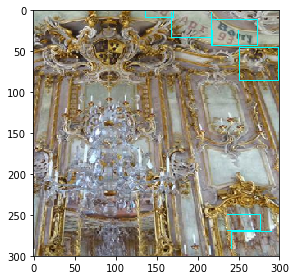

[[221, 236, 254, 52, 7, 76, 36, 45, 61], [245, 249, 255, 233, 256, 256, 178, 199, 233], [235, 251, 266, 74, 25, 104, 50, 68, 75], [273, 283, 291, 271, 295, 288, 201, 233, 255]]


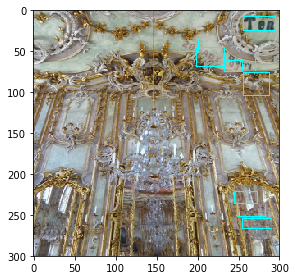

255.0 0.0
(300, 300, 3)
255.002 0.0
[[38, 59, 82, 4, 21, 40], [69, 71, 74, 40, 41, 43], [56, 78, 100, 20, 35, 54], [88, 90, 93, 59, 73, 66]]


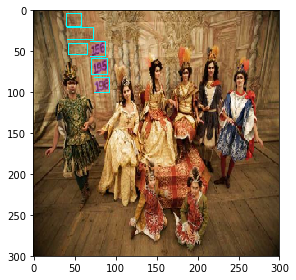

[[38, 59, 82, 4, 21, 40], [69, 71, 74, 40, 41, 43], [56, 78, 100, 20, 35, 54], [88, 90, 93, 59, 73, 66]]


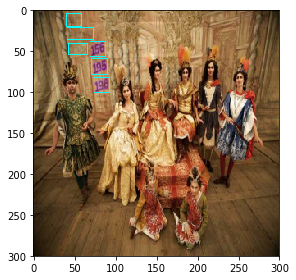

254.789 1.30071
(300, 300, 3)
255.0 0.0
[[183, 215, 247, -21, 29], [92, 77, 61, 64, 89], [245, 282, 326, 59, 113], [127, 115, 106, 114, 134]]


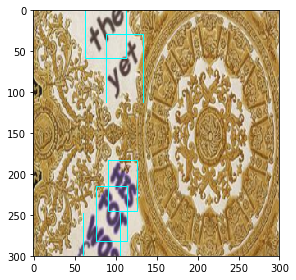

[[222, 15, 261, 168, 187, 206, 48, 78], [44, 104, 166, 72, 62, 52, 54, 70], [267, 44, 288, 205, 226, 252, 96, 127], [71, 134, 196, 94, 87, 81, 86, 99]]


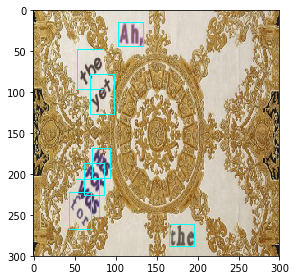

282.566 -50.9841
(300, 300, 3)
255.002 0.0
[[111, 84, 135, 118], [140, 164, 248, 100], [131, 110, 169, 133], [187, 210, 308, 141]]


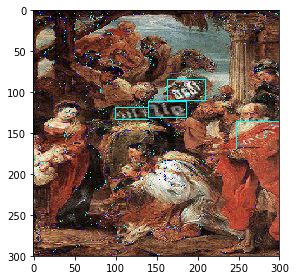

[[117, 92, 139, 124], [117, 100, 26, 152], [136, 116, 171, 137], [153, 135, 71, 184]]


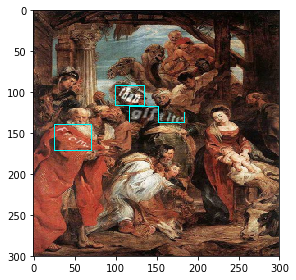

268.512 -17.0737
(300, 300, 3)
255.0 0.0
[[256, 56, 251, 259, 17], [221, 121, 234, 209, 90], [292, 71, 270, 271, 31], [292, 164, 265, 231, 143]]


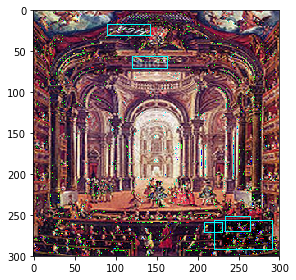

[[256, 56, 251, 259, 17], [7, 135, 34, 68, 156], [292, 71, 270, 271, 31], [78, 178, 65, 90, 209]]


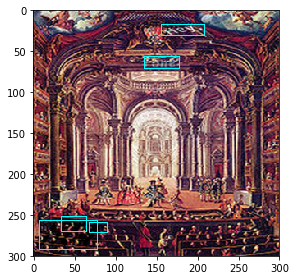

In [30]:
#out_shape = [700,700]
with tf.Graph().as_default(): 
    # build a net
    text_net = txtbox_300.TextboxNet()
    text_shape = text_net.params.img_shape
    print 'text_shape '+  str(text_shape)
    text_anchors = text_net.anchors(text_shape)
    
    ## dataset provider
    dataset = sythtextprovider.get_datasets('../data/sythtext/',file_pattern='*.tfrecord')
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
            dataset, common_queue_capacity=32, common_queue_min=2)
    
    [image, shape, glabels, gbboxes,height,width] = \
    data_provider.get(['image', 'shape',
                     'object/label',
                     'object/bbox','height','width'])

    
    image_train, tlabels, tbboxes,num = \
        txt_preprocessing.preprocess_image(image,  glabels,gbboxes,
                                        [300,300],data_format = 'NHWC', is_training=True)
    image_test, elabels, ebboxes, bbox_img,num = \
        txt_preprocessing.preprocess_image(image,  glabels,gbboxes, 
                                        [300,300],data_format = 'NHWC',is_training=False)
    batch_image = slim.batch_norm(image_train)
    #scala_image = tf.cast(image_train, tf.uint8)
    
    
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            for i in xrange(5):
                image_, batch_image_,image_test_,bbox_,test_box= sess.run([image_train,batch_image,image_test,tbboxes,ebboxes])
                #image_ = image_*255
                print image_.max(),image_.min()
                print image_.shape
                print image_test_.max(), image_test_.min()
                #image_ = image_ * 255.
                image_ = image_.astype(np.uint8)
                visualize_bbox(image_, bbox_)
                #image_test_ = image_test_ * 255.
                image_test_ = image_test_.astype(np.uint8)
                visualize_bbox(image_test_, test_box)
                
                

[[117, 92, 139, 124], [117, 100, 26, 152], [136, 116, 171, 137], [153, 135, 71, 184]]


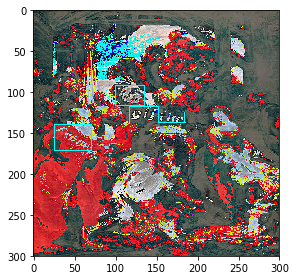

In [19]:
image_test_ = image_test_ * 255.0
image_test_ = image_test_.astype(np.uint8)
visualize_bbox(image_test_, test_box)


In [ ]:
image_ = image_ *255.0
image_ = image_.astype(np.uint8)
visualize_bbox(image_, bbox_)

In [ ]:
image_ = image_.astype(np.uint8)
#skio.imshow(np.uint8(image_bbox_p[0,:,:,:])*255)
skio.imshow(image_)

In [ ]:
for i in range(6):
    pmask = gscores_[i] > 0.5
    print np.sum(pmask)
bbox_

In [ ]:
for i in range(6):
    print np.where(gscores_[i] >0.1)
gscores_[0].shape

In [ ]:
loss

In [ ]:
pos_loss = 0
neg_loss = 0
for i in range(6):
    p_mask = np.int32(np.greater(b_gscores_[i] , 0.5))
    print np.sum(p_mask)
    n_mask = np.int32(np.less(b_gscores_[i] , 0.5))
    pos_loss += np.mean(pow((p_mask * (logits_[i][:,:,:,:,:,1] - p_mask)),2))
    neg_loss += np.mean(pow((n_mask * (logits_[i][:,:,:,:,:,0] - n_mask)),2))
print pos_loss,neg_loss